In [50]:
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
import matplotlib.pylab as plt
import scipy.sparse as sps
from random import randint
df = pd.read_csv('online_retail_transaction.csv',header=None,index_col=None)
df.shape # dimensione originale

(4372, 4223)

In [160]:
def compute_band_matrix(original_dataset=None, dim_finale=1000, nome__file_item=None, num_sensibile=1):
    """
        Compute band_matrix , permutazione casuale di righe e colonne
        estrapola a caso item_sensibili
    """
    if original_dataset is not None and len(original_dataset) >= dim_finale and len(original_dataset.columns) >= dim_finale:
        # leggo nomi items
        file = open(nome__file_item, "r")
        items = file.read().splitlines()
        # permuto righe e colonne del df inizale e prendo le prime :dim_finale
        np.random.seed(seed=20)
        random_column = np.random.permutation(df.shape[1])[:dim_finale]
        random_row = np.random.permutation(df.shape[0])[:dim_finale]
        # recupero gli item selezionati nel relativo ordine == colonne
        items_reordered = [items[i] for i in random_column]
        # df selezionato e square
        df_square = df.iloc[random_row][random_column];

        # selezioni gli utlimi num_sensibili come item sensibili
        # check se esiste almeno un item sensibile

        # remove dati sensibili add zero --> compute RCM --> remove zero e add dati sensibili
        # df_sensibili = df_square[df_square.columns[-num_sensibile:]]
        # df_common_items = df_square[df_square.columns[0:-num_sensibile]]
        # zero_data_to_add = np.zeros(shape=(len(df_common_items),num_sensibile))
        # columns_to_add = ["temp_"+str(x) for x in range(0,num_sensibile)]
        # df_zeri = pd.DataFrame(zero_data_to_add, columns=columns_to_add,index=df_common_items.index,dtype='uint8')
        # df_square = pd.concat([df_common_items,df_zeri],axis=1)
        # print(df_zeri.shape) dim_finalexnum_sensibili
        # print(df_square.shape)
        # subplot with y condiviso

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        lista_sensibili = df_square.columns[-num_sensibile:]
        # plot matrice sparsa iniziale
        # plt
        ax1.spy(df_square, marker='.', markersize='0.6')
        #ax1.show()

        # applicazione algoritmo RCM
        sparse = csr_matrix(df_square)
        order = reverse_cuthill_mckee(sparse)

        # solo se add gli 0
        # riordino i dati sensibili
        # df_sensibili = df_sensibili.iloc[order]

        # ora devo prendere gli item selzionati prima e riordinarli ancora
        # secondo quello scritto in order quindi
        items_final = [items_reordered[i] for i in order]
        column_reordered = [df_square.columns[i] for i in order]
        # df bandizzato
        df_square_band = df_square.iloc[order][column_reordered]
        # plotto
        ax2.spy(df_square_band, marker='.', markersize='0.6')
        
        #ax2.show()
        plt.show()
        # banda dataframe inizale
        [i, j] = np.where(df_square == 1)
        bw = max(i-j) + 1
        print("Bandwidth first RCM", bw)

        # banda dataframe dopo RCM
        [i, j] = np.where(df_square_band == 1)
        bw = max(i-j) + 1
        print("Bandwidth after RCM", bw)
        return df_square_band, items_final, lista_sensibili


def check_conflict(dataframe, row_i, row_j, items_sensibili):
    # se hanno un items sensibile in comune allora sono in conflitto
    dati_sensibili_row_i = items_sensibili[np.where(dataframe.iloc[row_i][items_sensibili] == 1)]
    dati_sensibili_row_j = items_sensibili[np.where(dataframe.iloc[row_j][items_sensibili] == 1)]
    # create set
    set_j = set(dati_sensibili_row_j)
    set_i = set(dati_sensibili_row_i)
    # check intersection
    return len(set_i.intersection(set_j)) > 0


def compute_hist(dataframe, items_sensibili):
    hist = dict(dataframe[items_sensibili].sum())
    return hist


def compute_candidate_list(dataframe, indice_transizione_sensibile, alpha_p, item_sensibili, all_transazioni_sensibili):
    lc = list()  # lista candidate
    k = 0;
    # controllo gli alpha*p transazioni prima che non sono in conflitto
    for i in range(indice_transizione_sensibile - 1, max(indice_transizione_sensibile - alpha_p - k, -1), -1):
        if i not in all_transazioni_sensibili:
            lc.append(i)
        else:
            if check_conflict(dataframe, indice_transizione_sensibile, i, item_sensibili):
                k += 1
            else:
                lc.append(i)
    # alpha*p transizioni dopo che non sono in conflitto
    k = 0
    for i in range(indice_transizione_sensibile + 1, min(indice_transizione_sensibile + alpha_p + k, len(dataframe)), +1):
        if i not in all_transazioni_sensibili:
            lc.append(i)
        else:
            if check_conflict(dataframe, indice_transizione_sensibile, i, items_sensibili):
                k += 1
            else:
                lc.append(i)

    return lc


def compute_similarity():
    return None


def CAHD(dataframe_bandizzato, items_sensibili, nome_item, grado_privacy, alfa=3):
    """
        funzione per il calcolo di CAHD su un dataframe_bandizzato dopo RCM
        con gli items sensibili (vedi paper per teoria)
    """
    # calcolo histogram per i dati sensibili
    hist = compute_hist(dataframe_bandizzato,items_sensibili)
    # lunghezza del dataframe
    remaining = len(dataframe_bandizzato)
    # gruppi anonimizzati
    # G = pd.DataFrame(columns=dataframe_bandizzato.columns)

    # inidice delle righe delle transazioni sensibili non ripetute
    transazioni_sensibili = list(set(list(np.where(dataframe_bandizzato[items_sensibili] == 1)[0])))
    # indice delle transizioni sensibili con mapping 1-1 con item_sensibile_per_transizione
    # transazioni_sensibili_completa[i] --> indice della transizione
    # item_sensibile_per_transazioni[i] --> item sensibile per la transizione sopra
    transazioni_sensibili_completa = list(np.where(dataframe_bandizzato[items_sensibili] == 1)[0])
    hash_transiction = dict()
    # item sensibili della transazione iesime
    item_sensibile_per_transazioni = list(np.where(dataframe_bandizzato[items_sensibili] == 1)[1])
    # riempo il dizionario (hash_map) indicizzata con il numero della riga
    for t in transazioni_sensibili:
        # primo elemento della tupla sono gli indici
        index_t = np.where(np.array(transazioni_sensibili_completa) == t)[0]
        hash_transiction[t] = [item_sensibile_per_transazioni[i] for i in index_t]

    # indicizzata le righe delle transizioni contententi l'indice della lista item_sensibili dove è contenuto l'uno
    # print(hash_transiction)
    lc_t = dict()
    for t in transazioni_sensibili:
        lc_t[t] = compute_candidate_list(dataframe_bandizzato, t, grado_privacy * alfa, items_sensibili, transazioni_sensibili)
        #    print(len(transazioni_sensibili))
        #    print(len(item_sensibile_per_transazioni))
        #    print(transazioni_sensibili[0])
        #    print(lc_t[t])



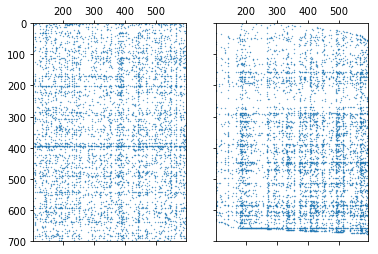

Bandwidth first RCM 691
Bandwidth after RCM 539


In [161]:
df_square,items,items_sensibili = compute_band_matrix(original_dataset = df, dim_finale = 700, nome__file_item="lista_items.txt",num_sensibile=4)
CAHD(df_square,items_sensibili,[],4)


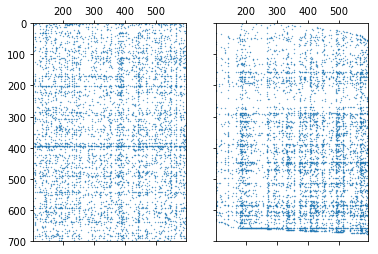

Bandwidth first RCM 691
Bandwidth after RCM 539
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


C:\Users\caput\Anaconda3\lib\site-packages\ipykernel\__main__.py:141: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


TypeError: only integer arrays with one element can be converted to an index

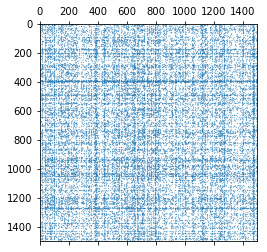

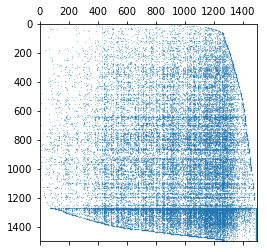

Bandwidth first RCM 1485
Bandwidth after RCM 1199


In [12]:
#print(items)
#print(items_sensibili)

['PINK MURANO TWIST BRACELET', 'S/2 BEACH HUT TREASURE CHESTS', 'RUBY GLASS CLUSTER BRACELET', 'HEAVENS SCENT FRAGRANCE OILS ASSTD', 'ORANGE FELT VASE + FLOWERS', 'ROSE DU SUD DRAWSTRING BAG', 'CANDY SPOT HEART DECORATION', 'SET 10 CARDS TRIANGLE ICONS  17220', 'SCALLOP SHELL SOAP DISH', 'BOXED GLASS ASHTRAY', 'WALL ART DOLLY GIRL ', 'CROCHET DOG KEYRING', 'GOLD FLOWER CUSHION COVER ', 'GLASS AND BEADS BRACELET IVORY', 'WALL ART SPACEBOY', 'Damages', 'FRYING PAN RED POLKADOT ', 'wrongly coded 23343', 'BAKING MOULD CUPCAKE CHOCOLATE', 'ORANGE/WHT/FUSCHIA STONES NECKLACE', 'RED STONE/CRYSTAL EARRINGS', 'rusty thrown away', 'REGENCY MIRROR WITH SHUTTERS', 'sold as set on dotcom and amazon', 'CRACKED GLAZE NECKLACE RED', 'HAPPY BIRTHDAY CARD STRIPEY TEDDY', 'OLD ROSE COMBO BEAD NECKLACE', 'METALIC LEAVES BAG CHARMS', 'METAL BASE FOR CANDLES', 'WATERING CAN SINGLE HOOK PISTACHIO', 'AMETHYST CHUNKY BEAD BRACELET W STR', 'WALL ART GARDEN HAVEN ', 'FOLDING UMBRELLA WHITE/RED POLKADOT', 'NEW EN

In [26]:
#df_square

,4116,1620,3904,2498,215,181,2769,389,2576,654,...,1356,2439,826,4210,3110,1127,4104,3623,4127,1375
3154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
a = [0, 0,0,1,2]

In [3]:
b = [2,1,1,3,3]

In [10]:
np.where(np.array(a)==0)

(array([0, 1, 2], dtype=int64),)